# normal knob

* configfle(knob): normal 처리됨
* total_internal_df: 이상치 처리됨

### total_internal_df 이상치 처리 부분
internal과 knob과의 상관관계 개수는 상관이 없다고 할 수 있을까? 그러니까 상관계수를 비교하는데 각각의 데이터의 차이를 보여도 될까...?


In [4]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import roc_auc_score

In [5]:
# knob 종류 및 바운드
knobs_rdb = {
    
    "hash-max-ziplist-entries":     (256, 751), 
    "hash-max-ziplist-value": (16, 257),
    "activerehashing": ('yes', 'no'),  ##yes
    "hz": (1, 41),
    "dynamic-hz": ('yes', 'no'),

    "save0_0": (700,1100),
    "save0_1": (1,9),
    "save1_0": (100,500),
    "save1_1": (10,100),
    "save2_0": (30,90),
    "save2_1": (8000,12000),

    "rdbcompression": ('yes', 'no'), ##yes
    "rdbchecksum": ('yes', 'no'),    ##yes
    "rdb-save-incremental-fsync": ('yes', 'no'),   ## yes

    "activedefrag": ('yes','no'),  
    "active-defrag-threshold-lower": (1, 31),
    "active-defrag-threshold-upper": (70, 101),
    "active-defrag-cycle-min": (1, 31),
    "active-defrag-cycle-max": (70, 91),
    
    "maxmemory": (1000, 2900),   ##"volatile-lru"
    "maxmemory-policy":     ("volatile-lru", "allkeys-lru", "volatile-lfu", "allkeys-lfu", 
                             "volatile-random","allkeys-random", "volatile-ttl", "noeviction"),
    "maxmemory-samples": (3, 7),
    
    "lazyfree-lazy-eviction": ('yes', 'no'),
    "lazyfree-lazy-expire": ('yes', 'no'),
    "lazyfree-lazy-server-del": ('yes', 'no')
}

knobs_list = list(knobs_rdb.keys())
knobs_bound = list(knobs_rdb.values())

## 데이터 전처리
* 이상치 파악
* test, train 데이터 잘 나뉘어졌는지 확인

In [6]:
# config(knob) data
config_df = pd.read_csv("./data/redis_config_normal4.csv", sep=',')


# external(throughput) data
external_df = pd.read_csv("./data/external_metrics0.csv", sep=',')

In [7]:
# config(knog), external(throughput) 데이터 하나의 프레임으로 결합
dataset = config_df
dataset['throughput'] = external_df['Gets_KB/sec']

In [8]:
dataset.head(3)

,appendonly,appendfsync,auto-aof-rewrite-percentage,auto-aof-rewrite-min-size,no-appendfsync-on-rewrite,aof-rewrite-incremental-fsync,aof-use-rdb-preamble,save0_0,save0_1,save1_0,...,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,throughput
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,877,5,309,...,5,no,no,yes,547,145,no,14,yes,61645.41
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,995,5,276,...,5,no,yes,no,528,137,no,19,no,63270.32
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,917,5,276,...,5,yes,yes,yes,511,163,no,17,yes,63602.49


In [9]:
# 결측치 처리 
dataset_nan = dataset.copy()
# activedefrag 만
subTotal_knobs_Active = dataset_nan.dropna()
Active_index = list(subTotal_knobs_Active.index)  # 인덱스


dataset = dataset.fillna(value = 0)  # 전부 0으로 채움

In [10]:
# Active_index

In [11]:
# maxmemory knob 단위(mb) 처리
dataset['maxmemory']  = dataset['maxmemory'].str.strip('mb')
dataset['maxmemory'] = pd.to_numeric(dataset['maxmemory'])

In [12]:
# Object 변수 categorical 로 변경 (LightGBM에 바로 넣기 위해)
category_knob = []

for knob in dataset:
    if dataset[knob].dtype == 'O':  # Object인 경우 category 형으로 변경
        dataset[knob] = dataset[knob].astype('category')
        if knob in knobs_list:
            category_knob.append(knob)

In [13]:
# 설정한 knob들만 추출
extract_knobs_list = knobs_list.copy()
extract_knobs_list.append('throughput')  # target 값 추가

dataset = dataset[extract_knobs_list]

In [14]:
# 결측치 처리전 확인
print(dataset_nan.info())

# 결측치 처리후 확인
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   appendonly                     0 non-null      float64
 1   appendfsync                    0 non-null      float64
 2   auto-aof-rewrite-percentage    0 non-null      float64
 3   auto-aof-rewrite-min-size      0 non-null      float64
 4   no-appendfsync-on-rewrite      0 non-null      float64
 5   aof-rewrite-incremental-fsync  0 non-null      float64
 6   aof-use-rdb-preamble           0 non-null      float64
 7   save0_0                        100 non-null    int64  
 8   save0_1                        100 non-null    int64  
 9   save1_0                        100 non-null    int64  
 10  save1_1                        100 non-null    int64  
 11  save2_0                        100 non-null    int64  
 12  save2_1                        100 non-null    int6

In [15]:
dataset.head(3)

,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,save0_0,save0_1,save1_0,save1_1,save2_0,...,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,maxmemory-policy,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,throughput
0,547,145,no,14,yes,877,5,309,48,61,...,90.0,13.0,81.0,2000,allkeys-lru,5,no,no,yes,61645.41
1,528,137,no,19,no,995,5,276,57,52,...,0.0,0.0,0.0,2800,allkeys-lfu,5,no,yes,no,63270.32
2,511,163,no,17,yes,917,5,276,61,67,...,0.0,0.0,0.0,1100,volatile-lru,5,yes,yes,yes,63602.49


<AxesSubplot:xlabel='save0_0', ylabel='Count'>

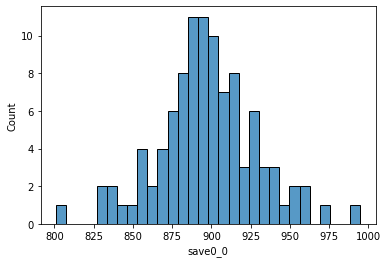

In [16]:
import seaborn as sns
sns.histplot(dataset['save0_0'], bins=30)

In [17]:
dataset['maxmemory-samples'].unique()

array([5, 6, 4])

## internal metrics

In [18]:
# cluster0 =[ 
# 'used_memory_rss',
# 'used_memory_rss_human',
# 'rss_overhead_ratio',
# 'rss_overhead_bytes',
# 'mem_fragmentation_ratio',
# 'mem_fragmentation_bytes']

# cluster1 = [
#     'uptime_in_seconds',
#     'hz',
#     'lru_clock',
#     'used_memory_peak',
#     'maxmemory',
#     'maxmemory_human',
#     'rdb_last_save_time',
#     'total_net_output_bytes',
#     'used_cpu_sys',
#     'used_cpu_user'
# ]

# cluster2 = [
#     'allocator_allocated',
#     'allocator_active',
#     'allocator_frag_bytes',
#     'instantaneous_ops_per_sec',
#     'instantaneous_input_kbps',
#     'instantaneous_output_kbps'
# ]

# cluster3 = [
#     'allocator_resident',
#     'allocator_rss_ratio',
#     'allocator_rss_bytes'  
# ]

cluster0 =[ 
    'allocator_allocated',
    'allocator_frag_bytes',
    'uptime_in_seconds',
    'used_memory_peak',
    'configured_hz',
    'used_cpu_sys',
    'maxmemory',
    'hz',
    'used_cpu_user',
    'maxmemory_human'
]

cluster1 = [
    'allocator_rss_bytes',
    'allocator_resident',
    'allocator_rss_ratio'
]

cluster2 = [
    'used_memory_rss',
    'rss_overhead_bytes',
    'mem_fragmentation_bytes',
    'used_memory_rss_human'
]


remove_knob = [
    'configured_hz', 'total_net_output_bytes', 'keyspace_hits', 'keyspace_misses'
]

knob_list = [
    "save0_0",
    "save0_1",
    "save1_0",
    "save1_1",
    "save2_0",
    "save2_1",

    "rdbcompression",
    "rdbchecksum",
    "rdb-save-incremental-fsync",

    "activedefrag",
    "active-defrag-threshold-lower",
    "active-defrag-threshold-upper",
    "active-defrag-cycle-min",
    "active-defrag-cycle-max",
    
    "maxmemory",
    
    "maxmemory-policy",
    "maxmemory-samples",
    "lazyfree-lazy-eviction",
    "lazyfree-lazy-expire",
    "lazyfree-lazy-server-del",

    "hash-max-ziplist-entries", 
    "hash-max-ziplist-value",
    "activerehashing",
    "hz",
    "dynamic-hz"
]

activedefrag_knobs = [
    "activedefrag",
    "active-defrag-threshold-lower",
    "active-defrag-threshold-upper",
    "active-defrag-cycle-min",
    "active-defrag-cycle-max",
]

In [19]:
# 데이터 불러오기 internal metrics와 knob들의 상관관계분석
import pandas as pd
internal_csv = pd.read_csv('./data/internal_metrics4.csv')

In [20]:
internal_csv

,redis_version,redis_git_sha1,redis_git_dirty,redis_build_id,redis_mode,os,arch_bits,multiplexing_api,atomicvar_api,gcc_version,...,repl_backlog_first_byte_offset,repl_backlog_histlen,used_cpu_sys,used_cpu_user,used_cpu_sys_children,used_cpu_user_children,cluster_enabled,db0:keys,expires,avg_ttl
0,6.2.1,0,0,c91470f75d7c181b,standalone,Linux 3.10.0-957.27.2.el7.x86_64 x86_64,64,epoll,atomic-builtin,4.8.5,...,0,0,8.846782,3.943008,0,0,0,249666,0,0
1,6.2.1,0,0,c91470f75d7c181b,standalone,Linux 3.10.0-957.27.2.el7.x86_64 x86_64,64,epoll,atomic-builtin,4.8.5,...,0,0,8.580880,3.920968,0,0,0,249666,0,0
2,6.2.1,0,0,c91470f75d7c181b,standalone,Linux 3.10.0-957.27.2.el7.x86_64 x86_64,64,epoll,atomic-builtin,4.8.5,...,0,0,8.847782,3.970934,0,0,0,249666,0,0
3,6.2.1,0,0,c91470f75d7c181b,standalone,Linux 3.10.0-957.27.2.el7.x86_64 x86_64,64,epoll,atomic-builtin,4.8.5,...,0,0,8.801138,3.874116,0,0,0,249666,0,0
4,6.2.1,0,0,c91470f75d7c181b,standalone,Linux 3.10.0-957.27.2.el7.x86_64 x86_64,64,epoll,atomic-builtin,4.8.5,...,0,0,8.811133,4.059362,0,0,0,249666,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6.2.1,0,0,c91470f75d7c181b,standalone,Linux 3.10.0-957.27.2.el7.x86_64 x86_64,64,epoll,atomic-builtin,4.8.5,...,0,0,10.325230,4.553343,0,0,0,249666,0,0
96,6.2.1,0,0,c91470f75d7c181b,standalone,Linux 3.10.0-957.27.2.el7.x86_64 x86_64,64,epoll,atomic-builtin,4.8.5,...,0,0,9.094565,4.039493,0,0,0,249666,0,0
97,6.2.1,0,0,c91470f75d7c181b,standalone,Linux 3.10.0-957.27.2.el7.x86_64 x86_64,64,epoll,atomic-builtin,4.8.5,...,0,0,8.761842,3.954245,0,0,0,249666,0,0
98,6.2.1,0,0,c91470f75d7c181b,standalone,Linux 3.10.0-957.27.2.el7.x86_64 x86_64,64,epoll,atomic-builtin,4.8.5,...,0,0,9.289759,4.111078,0,0,0,249666,0,0


In [21]:
# 컬럼 추출 함수
def extract_data(cluster_list, df):
    extracted_df = pd.DataFrame()
    for elem in cluster_list:
        extracted_df[elem] = df[elem]

    return extracted_df    

In [22]:
# 클러스터 합치기
cluster = cluster0+cluster1+cluster2
# cluster = cluster2

In [23]:
# 클러스터 요소에 해당되는 metrics 25개 추출
total_internal_df = extract_data(cluster, internal_csv)

In [24]:
# throughput 결측치 제거
total_internal_df.dropna()

,allocator_allocated,allocator_frag_bytes,uptime_in_seconds,used_memory_peak,configured_hz,used_cpu_sys,maxmemory,hz,used_cpu_user,maxmemory_human,allocator_rss_bytes,allocator_resident,allocator_rss_ratio,used_memory_rss,rss_overhead_bytes,mem_fragmentation_bytes,used_memory_rss_human
0,38658192,274288,22,38704616,7,8.846782,2831155200,7,3.943008,2.64,3276800,42209280,1.08,42033152,-176128,3410544,40.09
1,38656192,264000,22,38704616,32,8.580880,2306867200,32,3.920968,2.15,3289088,42209280,1.08,42053632,-155648,3431024,40.11
2,38658184,274296,22,38704616,40,8.847782,1782579200,40,3.970934,1.66,3276800,42209280,1.08,42037248,-172032,3414640,40.09
3,38656176,264016,22,38704624,37,8.801138,1048576000,37,3.874116,1000.00,3289088,42209280,1.08,42020864,-188416,3398256,40.07
4,38657736,274744,22,38704616,30,8.811133,1992294400,30,4.059362,1.86,3276800,42209280,1.08,42045440,-163840,3443824,40.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,38656208,263984,24,38704616,16,10.325230,1468006400,16,4.553343,1.37,3289088,42209280,1.08,42033152,-176128,3410544,40.09
96,38657176,263016,23,38704616,25,9.094565,2621440000,25,4.039493,2.44,3276800,42196992,1.08,42024960,-172032,3402352,40.08
97,38658328,274152,22,38704616,35,8.761842,2621440000,35,3.954245,2.44,3276800,42209280,1.08,42004480,-204800,3381872,40.06
98,38656632,263560,23,38704632,3,9.289759,1992294400,3,4.111078,1.86,3289088,42209280,1.08,42037248,-172032,3414640,40.09


In [25]:
def get_outlier(df=None, column=None, weight=1.5):
    
    # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight

    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight

    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

# 함수 사용해서 이상치 값 삭제
# outlier_idx = get_outlier(df=total_internal_df, column='used_memory_rss', weight=1.5)

# internal = total_internal_df.drop(outlier_idx, axis=0)
# knob = dataset.drop(outlier_idx, axis=0)

In [26]:
numerical_var= ['save0_0',
 'save0_1',
 'save1_0',
 'save1_1',
 'save2_0',
 'save2_1',
 'maxmemory',
 'maxmemory-samples',
 'hash-max-ziplist-entries',
 'hash-max-ziplist-value',
 'hz']

In [33]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import pointbiserialr

internal_exit_pv = []

def get_corr_withoutOutlier(internal_m, knob):
    nan_corr_var = ['rss_overhead_ratio', 'mem_fragmentation_ratio', 'used_memory_peak','total_net_output_bytes', 'allocator_active', 'allocator_resident', 'allocator_rss_ratio', 'allocator_rss_bytes']
    
    if internal_m in nan_corr_var:
        corr_result = pearsonr(total_internal_df[internal_m], dataset[knob])
        if corr_result[1] <=0.05:
            internal_exit_pv.append(internal_m)
            return corr_result[0]
#             print(corr_result[0])
        return 999

    outlier_idx = get_outlier(df=total_internal_df, column=internal_m, weight=1.5)  # outlier의 인덱스를 받는다. 
    
#     sns.histplot(dataset[knob])
#     plt.show()
    
    internal = total_internal_df.drop(outlier_idx, axis=0)
    knobdata = dataset.drop(outlier_idx, axis=0)
    
    corr_result = pearsonr(internal[internal_m], knobdata[knob])
    if corr_result[1] <=0.05:
        internal_exit_pv.append(internal_m)
#         print(corr_result[0])
        return corr_result[0]
    return 999


def get_corr_withoutOutlier_bool(internal_m, knob):
    nan_corr_var = ['rss_overhead_ratio', 'mem_fragmentation_ratio', 'used_memory_peak','total_net_output_bytes', 'allocator_active', 'allocator_resident', 'allocator_rss_ratio', 'allocator_rss_bytes']
    
#     knob = 'hash-max-ziplist-value'
    
    if internal_m in nan_corr_var:
        corr_result = pointbiserialr(total_internal_df[internal_m], dataset[knob])
        if corr_result[1] <=0.05:
            internal_exit_pv.append(internal_m)
            return corr_result[0]
#             print(corr_result[0])
        return 0

    outlier_idx = get_outlier(df=total_internal_df, column=internal_m, weight=1.5)  # outlier의 인덱스를 받는다. 
    
#     sns.histplot(dataset[knob])
#     plt.show()
    
    internal = total_internal_df.drop(outlier_idx, axis=0)
    knobdata = dataset.drop(outlier_idx, axis=0)
    
    corr_result = pointbiserialr(internal[internal_m], knobdata[knob])
    if corr_result[1] <=0.05:
        internal_exit_pv.append(internal_m)
#         print(corr_result[0])
        return corr_result[0]
    return 0




In [28]:
dataset.head()

,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,save0_0,save0_1,save1_0,save1_1,save2_0,...,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,maxmemory-policy,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,throughput
0,547,145,no,14,yes,877,5,309,48,61,...,90.0,13.0,81.0,2000,allkeys-lru,5,no,no,yes,61645.41
1,528,137,no,19,no,995,5,276,57,52,...,0.0,0.0,0.0,2800,allkeys-lfu,5,no,yes,no,63270.32
2,511,163,no,17,yes,917,5,276,61,67,...,0.0,0.0,0.0,1100,volatile-lru,5,yes,yes,yes,63602.49
3,578,110,yes,19,yes,877,5,296,48,68,...,0.0,0.0,0.0,1600,allkeys-lfu,6,no,yes,yes,63679.99
4,497,135,yes,24,yes,912,6,279,66,57,...,90.0,11.0,82.0,1400,allkeys-lru,5,no,no,yes,60092.30


In [29]:
numeric = ['hash-max-ziplist-entries',
 'hash-max-ziplist-value',
 'hz',
 'save0_0',
 'save0_1',
 'save1_0',
 'save1_1',
 'save2_0',
 'save2_1',
 'active-defrag-threshold-lower',
 'active-defrag-threshold-upper',
 'active-defrag-cycle-min',
 'active-defrag-cycle-max',
 'maxmemory',
 'maxmemory-samples',
 ]

boolean = ['rdbcompression',
 'rdbchecksum',
 'rdb-save-incremental-fsync',
 'lazyfree-lazy-eviction',
 'lazyfree-lazy-expire',
 'lazyfree-lazy-server-del',
 'activerehashing',
 'dynamic-hz']

In [30]:
# # 결과 데이터 프레임 생성
# # corr_result = pd.DataFrame(index = numeric)
# corr_result['cluster2'] = cluster_k_corr_var

In [31]:
# corr_result

In [34]:
# knob_li = knob.columns 
# knob_li.remove('throughput')

import numpy as np

cluster_k_corr_var = []

for knob in dataset[numeric]:
    print('######{}######'.format(knob))

    for internal in total_internal_df:
        result = 999
        result = get_corr_withoutOutlier(internal, knob)
        if result != 999:
            print(internal)
            print(result)        
                

        

######hash-max-ziplist-entries######
######hash-max-ziplist-value######
configured_hz
0.23781502095521106
hz
0.23781502095521106
######hz######
######save0_0######
used_cpu_sys
-0.32903182300166617
used_memory_rss
0.2617889587242688
mem_fragmentation_bytes
0.2781168681054153
######save0_1######
######save1_0######
######save1_1######
allocator_rss_ratio
0.20279538324824575
######save2_0######
mem_fragmentation_bytes
-0.3013819738790862
######save2_1######


/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


######active-defrag-threshold-lower######
######active-defrag-threshold-upper######
######active-defrag-cycle-min######
######active-defrag-cycle-max######
######maxmemory######
######maxmemory-samples######


######rdbcompression######
allocator_allocated


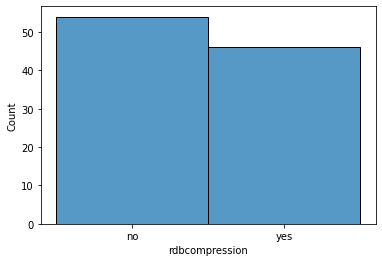

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U3')) -> None

In [66]:
# for knob in dataset[boolean]:
#     print('######{}######'.format(knob))
#     result_corrs = []
#     for internal in total_internal_df:
#         print(internal)
#         result_corrs.append(get_corr_withoutOutlier_bool(internal, knob)) 
#     num_result = np.array(result_corrs)
#     cluster_k_corr_var.append(np.mean(num_result).tolist()) 